In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import json
import pandas as pd
from mol_gen_docking.data.pdb_uniprot.target_naming import fetch_uniprot_id_from_pdbid
from tqdm import tqdm
from multiprocessing import Pool
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

# Targets

In [3]:
def plot_all_cols(df, N_COLS, fig, escape=["smiles", "pdb_id"]):
    outer_grid = fig.add_gridspec(N_COLS, 1, wspace=0.1, hspace=0.5)


    i = 0
    j = 0
    n_cols = (df[[c for c in df.columns if not c in escape]].shape[1]-1) // N_COLS +1

    grid = outer_grid[0].subgridspec(1, ncols=n_cols)

    for col in df.columns:
        if col not in escape:
            ax = plt.subplot(grid[i])
            sns.histplot(df[col], bins=100, ax=ax)
            ax.set_title(col)
            i += 1
            if i == n_cols and not j == N_COLS - 1:
                i = 0
                j += 1
                if j == N_COLS - 1:
                    grid = outer_grid[j].subgridspec(1, ncols=n_cols + (df[[c for c in df.columns if not c in escape]].shape[1]-1) % N_COLS)
                else:
                    grid = outer_grid[j].subgridspec(1, ncols=n_cols)

# df = pd.read_csv("data/properties.csv", index_col=0)
# fig = plt.figure(figsize=(20, 10))
# plot_all_cols(df, 4, fig, escape=["smiles", "pdb_id"])

In [4]:
DATA_PATH = "data/molgendata"
with open(os.path.join(DATA_PATH, "pockets_info.json")) as f:
    data = json.load(f)

with open(os.path.join(DATA_PATH, "docking_targets.json")) as f:
    targ = json.load(f)

data = {k: data[k]["metadata"] for k in data if k in targ}
target_info = pd.DataFrame.from_dict(data).transpose()
target_info["origin"] = target_info["origin"].fillna("sair")

target_info["volume (nm$^3$)"] = target_info["size"].apply(lambda x: np.prod(x)/1000)

def get_activity_val(row: pd.Series):
    if not np.isnan(row.avg_pIC50):
        return row.avg_pIC50
    else:
        return row.avg_pKd

def get_activity_label(row: pd.Series):
    if not np.isnan(row.avg_pIC50):
        return "pIC50"
    else:
        return "pKd"

target_info["Average labeled activity"] = target_info.apply(get_activity_val, axis=1)
target_info["activity unit"] = target_info.apply(get_activity_label, axis=1)
target_info = target_info.sort_values("prot_id", ascending=False)
target_info

,size,center,sequence,prot_id,origin,avg_pIC50,cluster,n_ligand_poses,avg_confidence,avg_pKd,volume (nm$^3$),Average labeled activity,activity unit
sample_1182983_model_0,"[14.8069, 20.13453, 15.866261]","[0.4397602, -7.5248146, -5.88239]",MKQLTILGSTGSIGCSTLDVVRHNPEHFRVVALVAGKNVTRMVEQC...,W8T2T2,sair,6.6316,1,6,0.924242,NaN,4.730208,6.631600,pIC50
sample_1182955_model_0,"[16.70844, 19.59416, 21.942749]","[20.05296, 2.67282, 4.701095]",MEEDDNLKKGNERNKKKAIFSNDDFTGEDSLMEDHLELREKLSEDI...,W7JX98,sair,8.422222,1,13,0.895301,NaN,7.183789,8.422222,pIC50
sample_1182938_model_0,"[25.79832, 15.09382, 25.83973]","[4.6394696, 5.70941, -6.372835]",MATLKDQLIYNLLKEEQTPQNKITVVGVGAVGMACAISILMKDLAD...,V9HWB9,sair,5.52,1,7,0.949922,NaN,10.061867,5.520000,pIC50
sample_1182916_model_0,"[15.043381, 11.71337, 18.99319]","[-2.9652102, -17.871904, -6.8495255]",MAKAAAIGIDLGTTYSCVGVFQHGKGERNVLIFDLGGGTFDVSILT...,V9GZ37,sair,4.335973,7,8,0.75928,NaN,3.346765,4.335973,pIC50
sample_1182861_model_0,"[20.5526, 15.60688, 19.912409]","[-0.11782026, -4.9323196, 15.933545]",GTGNTGETLGEKWKNRLNSLGKSEFQIYKRSGIQEVDRTLAKEGIK...,V5TFZ2,sair,6.088769,3,17,0.883548,NaN,6.387143,6.088769,pIC50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_592_model_0,"[18.33927, 15.96632, 15.86145]","[-7.4689646, 7.3291197, -3.532755]",MGNPILAGLGFSLPKRQVSNHDLVGRINTSDEFIVERTGVRTRYHV...,A0A0C7ACN7,sair,5.81675,1,6,0.911108,NaN,4.644402,5.816750,pIC50
sample_541_model_0,"[21.69623, 17.19915, 17.76338]","[-10.726674, 1.9289751, 8.28267]",MPIHNLNHVNMFLQVIASGSISSAARILRKSHTAVSSAVSNLEIDL...,A0A072ZLE6,sair,5.49625,1,3,0.86693,NaN,6.628525,5.496250,pIC50
sample_509_model_0,"[21.4182, 20.06414, 16.193619]","[4.20965, 4.00511, 11.38122]",MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,A0A059UE90,sair,8.331377,1,36,0.905851,NaN,6.959010,8.331377,pIC50
sample_390_model_0,"[24.44623, 13.335131, 20.32432]","[-8.773644, -3.7128851, -7.8022604]",MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,A0A045ISB3,sair,6.271797,1,80,0.859692,NaN,6.625600,6.271797,pIC50


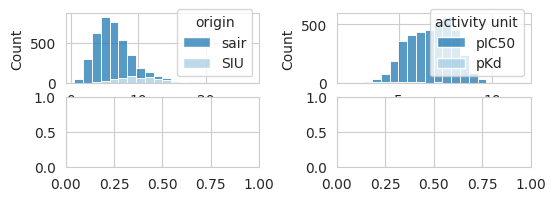

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(6, 2), )
axes = axes.flatten()

plt.subplots_adjust(wspace=0.4)
axes = axes.flatten()
cols = [("volume (nm$^3$)","origin"), ("Average labeled activity", "activity unit")]
palette = sns.color_palette("Paired", n_colors=2)[::-1]

for ax, col in zip(axes, cols):
    if len(col) == 1:
        sns.histplot(target_info, x=col[0], bins=20, hue=col[1], ax=ax, multiple="stack", palette=palette)
    else:
        sns.histplot(target_info, x=col[0], bins=20, ax=ax, hue=col[1], multiple="stack", palette=palette)



In [13]:
(20*10**-10)**3 / 10**-27



8.000000000000002

In [14]:
import requests

def get_info(uniprot_id):
    try:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            raise ValueError(f"UniProt ID {uniprot_id} not found.")
        data = response.json()
        data["organism"] = data.get("organism", {})
        prt_ex = None
        if "proteinExistence" in data:
            prt_ex = data["proteinExistence"]
        elif "inactiveReason" in data:
            prt_ex = data["inactiveReason"]["deletedReason"]
        else:
            prt_ex = "5: Uncertain"
        out = dict(
            molecular_func = "unknown",
            uniprot_score = data["annotationScore"],
            organism= data["organism"].get("scientificName", "unk"),
            proteinExistence= prt_ex,
            organism_path=data["organism"].get("lineage", np.nan),
            len_lineage=len(data["organism"].get("lineage", [])),
        )
        mol_func = []
        if "keywords" in data:
            for kyw in data["keywords"]:
                if kyw["category"] == "Molecular function":
                    mol_func.append(kyw["name"])
            out["molecular_func"] = mol_func
        else:
            out["molecular_func"] = "unk"
    except Exception as e:
        return None
    return out

In [15]:
get_info(target_info.prot_id[0])

{'molecular_func': ['Isomerase', 'Oxidoreductase'],
 'uniprot_score': 3.0,
 'organism': 'Escherichia coli',
 'proteinExistence': '3: Inferred from homology',
 'organism_path': ['Bacteria',
  'Pseudomonadati',
  'Pseudomonadota',
  'Gammaproteobacteria',
  'Enterobacterales',
  'Enterobacteriaceae',
  'Escherichia'],
 'len_lineage': 7}

In [ ]:
pool = Pool(64)
uniprot_ids = target_info["prot_id"].unique()
infos = {
    uniprot_id: inf for uniprot_id, inf in zip(
        uniprot_ids,
        list(
            tqdm(
                pool.imap(get_info, uniprot_ids),
                total=len(uniprot_ids)
            )
        )
    )
}
del pool

In [ ]:
failed = [k for k in infos if infos[k] is None]
print(len(failed))
pool = Pool(16)
uniprot_ids = failed
new_infos = {
    uniprot_id: inf for uniprot_id, inf in zip(
        uniprot_ids,
        list(
            tqdm(
                pool.imap(get_info, uniprot_ids),
                total=len(uniprot_ids)
            )
        )
    )
}
for unip, v in new_infos.items():
    if v is not None:
        infos[unip] = v

del pool


In [ ]:
for k in list(infos[list(infos.keys())[0]].keys()):
    target_info[k] = target_info["prot_id"].apply(lambda id: infos[id][k])


In [ ]:
target_info.to_csv("data/tmp.csv")

In [ ]:
target_info_df = pd.read_csv("data/tmp.csv")
def decode_org(org_path):
    if isinstance(org_path, str) and not org_path=="unk":
        return json.loads(org_path.replace("'",'''"'''))
    return org_path

target_info_df.organism_path = target_info_df.organism_path.apply(decode_org)
target_info_df.molecular_func = target_info_df.molecular_func.apply(decode_org)


In [ ]:
target_info_df

In [ ]:
# Re arrange path for lineage

lineage_max = target_info_df["len_lineage"].max()

def get_lineage(df, idx_forb):
    lineage_df = df[["prot_id", "organism", "organism_path", "len_lineage"]]
    lineage_df["organism_path"] = lineage_df["organism_path"].apply(lambda L: [L[i] for i in range(len(L)) if not i in idx_forb or i == len(L) - 1])


    leaf_list = [L[-1] for L in lineage_df["organism_path"]]
    lineage_df["leaf_reached"] = False
    for k in range(lineage_max+1):
        lineage_df["lineage_{}".format(k)] = lineage_df.apply(
            lambda row: None if len(row["organism_path"]) <= k or row["leaf_reached"] else row["organism_path"][k],
            axis=1
        )
        lineage_df["leaf_reached"] = lineage_df.apply(lambda row: row["leaf_reached"] or row["lineage_{}".format(k)] in leaf_list, axis=1)

    lineage_df["org_path_hash"] = lineage_df.apply(lambda row: "".join([row["lineage_{}".format(k)] for k in range(lineage_max) if not row["lineage_{}".format(k)] is None]), axis=1)

    count_organism = lineage_df.groupby("org_path_hash").prot_id.nunique().to_frame().rename(columns={"prot_id": "organism_count"})

    lineage_df = lineage_df.join(count_organism, on="org_path_hash")
    lineage_df = lineage_df.drop(["prot_id", "organism_path", "organism", "len_lineage"], axis=1).drop_duplicates()
    return lineage_df

In [ ]:
import warnings
warnings.filterwarnings("ignore")

lineage_df = get_lineage(target_info_df[~target_info_df.organism_path.isna()], [1,2,3,4,5,7,8] + list(range(10,lineage_max+1)))
fig = px.sunburst(lineage_df, path=[f"lineage_{k}" for k in range(15)], values='organism_count', width=600, height=600,)
fig.update_layout(
    font=dict(size=20),
    )
fig.show()

In [ ]:
fn_count = {}
target_info_df.molecular_func = target_info_df.molecular_func.apply(lambda x: [x] if not isinstance(x, list) else x)
for mol_fns in target_info_df.molecular_func:
    for fn in mol_fns:
        fn_count[fn] = fn_count.get(fn, 0) + 1

max_len_func = target_info_df.molecular_func.apply(len).max()
taxonomy: dict[str,str] = {} # Parent -> Child
for iteration in tqdm(range(max_len_func)):
    for mol_fns in target_info_df.molecular_func:
        if len(mol_fns) < iteration + 1:
            continue
        # Get largest parent not already in taxonomy
        ordered_mol_fns = sorted(mol_fns, key=fn_count.get)[::-1]
        for i in range(len(ordered_mol_fns)-1):
            if not ordered_mol_fns[i] in taxonomy:
                taxonomy[ordered_mol_fns[i]] = ordered_mol_fns[i+1]
                break

len(taxonomy), len(fn_count)

In [ ]:
counts = fn_count

In [ ]:
child_to_parent = {child: parent for parent, child in taxonomy.items()}

def build_path(leaf):
    path = [leaf]
    while path[-1] in child_to_parent:
        path.append(child_to_parent[path[-1]])
    return path[::-1]  # reverse to have root -> leaf

# Build DataFrame for all leaves (all nodes in counts)
import pandas as pd

rows = []
for node in counts.keys():
    path = build_path(node)
    rows.append(path + [counts[node]])  # add count as last column

# Determine the max depth
max_depth = max(len(r) for r in rows)

# Pad paths to same length for DataFrame
for r in rows:
    while len(r) < max_depth + 1:
        r.insert(-1, np.nan)  # insert empty strings before count

# Column names: Level1, Level2, ..., Count
col_names = [f"level{i+1}" for i in range(max_depth)] + ["count"]

df = pd.DataFrame(rows, columns=col_names)

def get_longest_path(df, value):
    return (~df[df["level1"] == value].isna()).sum(1).max() - 2

for value in df.level1.unique():
    length = get_longest_path(df, value)
    for i in range(df.shape[0]):
        for depth in range(2,length+2):
            if df.level1[i] == value and df[f"level{depth}"].isna()[i] and df[f"level{depth-1}"][i] != "" and ~df[f"level{depth-1}"].isna()[i]:
                df[f"level{depth}"].iloc[i] = ""


df


In [ ]:
import plotly.graph_objects as go
parents = []
children = []
labels = []

for val in df.level1.unique():
    parents.append("")
    children.append(val)
    labels.append(counts[val])

for lvl in range(2,5):
    for val in df[f"level{lvl}"].unique():
        if not val in [np.nan, ""]:
            parent = df[df[f"level{lvl}"] == val][f"level{lvl-1}"].iloc[0]
            parents.append(parent)
            children.append(val)
            labels.append(counts[val])


fig =px.sunburst(
        names=children,
        parents=parents,
        values=labels, width=800, height=800
)
fig.update_layout(
    font=dict(size=20),
    )

fig.show()

In [ ]:
fig = t(
    df,
    path=[f"level{i+1}" for i in range(2)],
    values="count",
    width=800,
    height=800,
)
fig.show()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
target_info_df["Protein existence"] = target_info_df.proteinExistence.apply(lambda x: x if ":" in x else "5: Uncertain")
order = target_info_df.molecular_func.value_counts().sort_values()[::-1].index.tolist()[:10]

target_info_df.rename(columns={"uniprot_score": "Annotation Score"}, inplace=True)
target_info_df["Annotation Score"] = pd.Categorical(target_info_df["Annotation Score"], [1.,2.,3.,4.,5.])


palette = {
    k: sns.color_palette("coolwarm", as_cmap=True)((int(k.split(':')[0])-1)/4) for k in target_info_df["Protein existence"].unique()
}

sns.histplot(data = target_info_df.sort_values("Protein existence", ascending=True), x = "Annotation Score", hue="Protein existence", multiple="stack", ax=ax, palette=palette, binwidth=.2)
ax.set_xlabel("")
sns.move_legend(
    ax, "upper left",
 ncol=1,fontsize=9
)
ax.tick_params(axis="x", rotation=90)
# plt.yscale("log")

plt.savefig("target_mol_fn.png", dpi=300, bbox_inches="tight")

In [ ]:
target_info_df.molecular_func.unique().tolist()

# Prompts

In [4]:
from mol_gen_docking.data.pydantic_dataset import read_jsonl
from pathlib import Path

def load(path:str):
    data = read_jsonl(Path(path))
    return [line.conversations[0].meta for line in data]

data_dir = "data/molgendata"
with open(os.path.join(data_dir, "pockets_info.json")) as f:
    pockets = json.load(f)
with open(os.path.join(data_dir, "docking_targets.json")) as f:
    docking_targets = json.load(f)

data = {}
for d in os.listdir(os.path.join(data_dir)):
    directory = os.path.join(data_dir, d)
    if d.endswith(".jsonl"):
        data[d.split(".")[0]] = load(Path(directory))
    if os.path.isdir(directory):
        for f in os.listdir(directory):
            if f.endswith(".jsonl"):
                data[f.split(".")[0]] = load(Path(os.path.join(directory, f)))


In [5]:
def transf(x):
    if x in pockets:
        return "docking"
    return x.replace("Calc", "").replace("Bonds", "B.").replace("Rings", "R.")

def get_df(data_d):
    df = pd.DataFrame(data_d)
    df = df.drop(columns=["docking_metadata"])
    df= df.explode(["properties", "objectives", "target"]).reset_index(drop=True)
    df["is_docking"] = df["properties"].apply(lambda x: x in docking_targets)

    df["reward_type"] = df.properties.apply(transf)
    return df


In [6]:
data.keys()

dict_keys(['train_prompts', 'eval_prompts_ood', 'eval_prompts', 'test_prompts', 'test_prompts_ood'])

In [7]:
df = get_df(data["train_prompts"])
df

,properties,objectives,target,prompt_id,n_props,n_docking_props,source,is_docking,reward_type
0,sample_1182682_model_0,minimize,0.0,347010,1,1,train_prompts,True,docking
1,CalcNumHBD,above,2.0,3911220,1,0,train_prompts,False,NumHBD
2,CalcNumHBA,above,2.0,3910220,1,0,train_prompts,False,NumHBA
3,1arz_PDC_D_303,below,-10.69,3907239213-106,2,1,train_prompts,True,docking
4,QED,above,0.37,3907239213-106,2,1,train_prompts,False,QED
...,...,...,...,...,...,...,...,...,...
115986,QED,maximize,0.0,1966103906318390700,3,1,train_prompts,False,QED
115987,logP,below,-5.72,39173-577210,2,1,train_prompts,False,logP
115988,sample_345954_model_0,minimize,0.0,39173-577210,2,1,train_prompts,True,docking
115989,sample_626260_model_0,minimize,0.0,1931103906319,2,1,train_prompts,True,docking


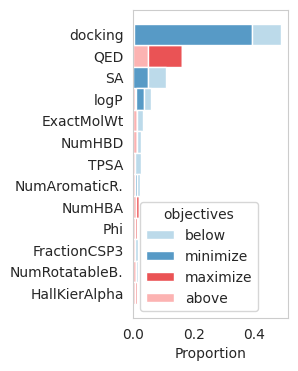

In [26]:
ks = ["test_prompts", "test_prompts_ood"]
df = pd.concat([get_df(data[k]) for k in ks]).reset_index(drop=True)
palette = {
    "below": sns.color_palette("Paired", n_colors = 6)[0],
    "minimize": sns.color_palette("Paired", n_colors = 6)[1],
    "above":sns.color_palette("Paired", n_colors = 6)[4],
    "maximize":sns.color_palette("Paired", n_colors = 6)[5],
}
order = df.groupby("reward_type").count().sort_values("prompt_id").index[::-1]
df["reward_type"] = pd.Categorical(df["reward_type"], categories=order)
fig, ax = plt.subplots(1,1, figsize=(2,4))

_ = sns.histplot(df, y="reward_type", hue = "objectives",  palette=palette, multiple = "stack", stat="proportion", ax=ax)
labels = ax.get_xticklabels()
ax.set_xlabel("")
ax.grid(False)
ax.set_xlabel("Proportion")
ax.set_ylabel("")
fig.savefig("../-Philippe-MolGenDocking/Figures/generation_data/reward_type.pdf", bbox_inches="tight")

In [27]:
def reward_combinations(sub_df):
    all_rewards = sub_df["reward_type"].tolist()
    n_docking = sub_df["is_docking"].sum()
    out = ""
    if "docking" in all_rewards:
        if n_docking > 1:
            if len(all_rewards) == 2:
                return "2-docking"
            return "2-docking + ..."
        else:
            out += "docking + "
    elif len(all_rewards) == 1:
        return "other"
    if "QED" in all_rewards:
        out += "QED + "
    if "SA" in all_rewards:
        out += "SA + "

    for r in all_rewards:
        if not r in ["docking", "QED", "SA"]:
            out += "other + "
    if out == "":
        raise ValueError(all_rewards)
    return out[:-3]


In [28]:
ks = ["test_prompts", "test_prompts_ood"]
df = pd.concat([get_df(data[k]) for k in ks]).reset_index(drop=True)

df_ragg = df.groupby(["prompt_id", "n_props"]).apply(reward_combinations).to_frame().rename(columns={0:"p"})
df_ragg = df_ragg.groupby("n_props").p.value_counts()/df_ragg.groupby("n_props").p.count()
df_ragg = df_ragg.reset_index()
df_ragg = df_ragg.rename(
    columns={
        "p": "type", 0: "proportion"
    }
)


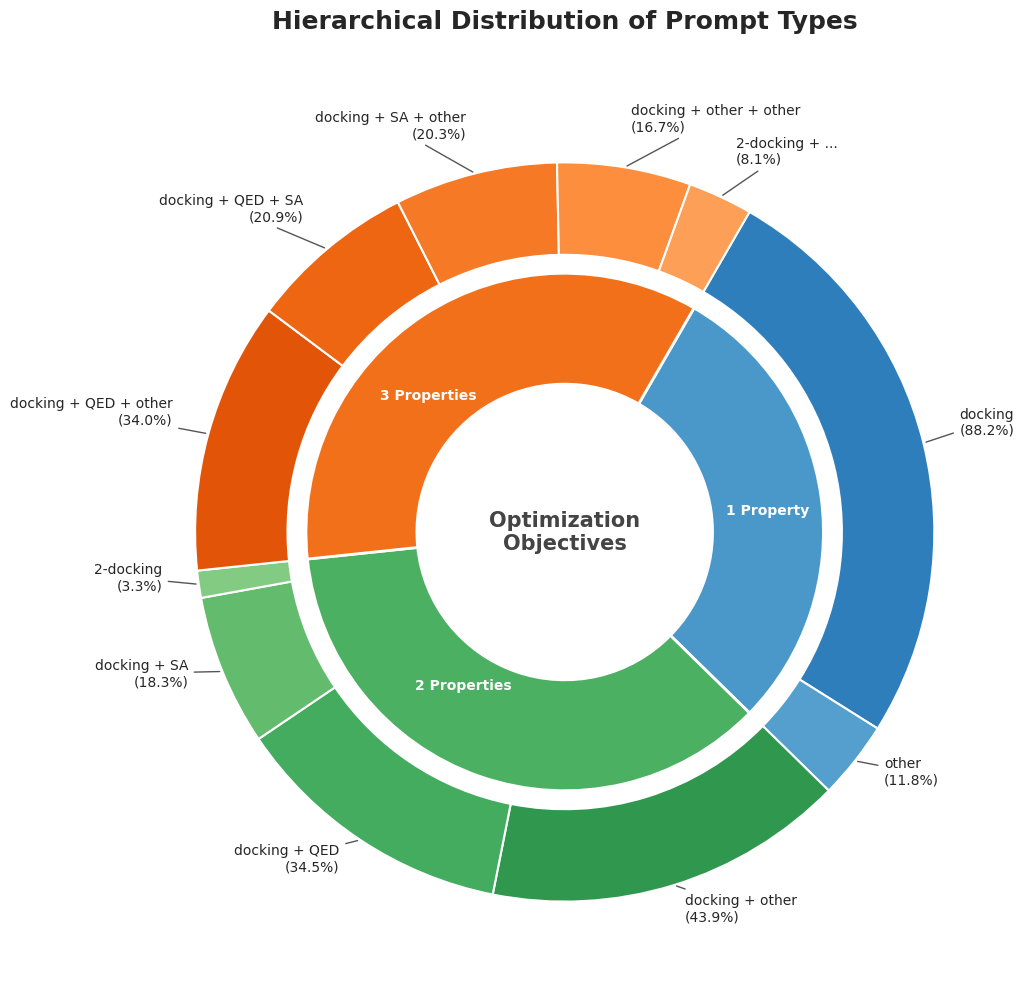

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. DATA PREPARATION
df_csv = df_ragg

# Calculate inner proportions (Replace this with your original df.groupby logic if needed)
# Here I use placeholder values matching your draft
inner_proportions = {
    '1 Property': 0.29,
    '2 Properties': 0.36,
    '3 Properties': 0.35
}

# 2. COLOR PALETTE DEFINITION
# We use colormaps to generate matching shades for subgroups
cmaps = [plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges]
inner_colors = [cmaps[0](0.6), cmaps[1](0.6), cmaps[2](0.6)]

outer_sizes = []
outer_labels = []
outer_colors = []
outer_relative_pct = []

for i, (group_name, inner_p) in enumerate(inner_proportions.items()):
    n = int(group_name.split()[0])
    sub_df = df_csv[df_csv['n_props'] == n].sort_values('proportion', ascending=False)

    for j, (_, row) in enumerate(sub_df.iterrows()):
        outer_sizes.append(row['proportion'] * inner_p)
        outer_labels.append(row['type'])
        outer_relative_pct.append(row['proportion'] * 100)
        # Create shades: darker for the largest subgroup, lighter for the others
        shade = 0.7 - (j / (len(sub_df) + 1)) * 0.4
        outer_colors.append(cmaps[i](shade))

# 3. PLOTTING
fig, ax = plt.subplots(figsize=(12, 12), dpi=100)

# Outer Ring
wedges_out, _ = ax.pie(
    outer_sizes, radius=1, colors=outer_colors,
    startangle=60, counterclock=False,
    wedgeprops=dict(width=0.25, edgecolor='white', linewidth=1.5)
)
# 1. Define Geometry
inner_rad = 0.7
inner_w = 0.3
inner_label_pos = (inner_rad - inner_w/2) / inner_rad *0.8
# Inner Ring
wedges_in, texts_in = ax.pie(
    list(inner_proportions.values()),
    labels=list(inner_proportions.keys()),
    radius=inner_rad, colors=inner_colors,
    startangle=60, counterclock=False,
    labeldistance=inner_label_pos,
    textprops={'color': 'white', 'weight': 'bold', 'fontsize': 10},
    wedgeprops=dict(width=inner_w, edgecolor='w', linewidth=2)
)

# 4. PRETTIFY LABELS (Callouts for the outer ring)
for i, p in enumerate(outer_sizes):
    # Only label segments larger than 1.5% to prevent clutter
    if (p / sum(outer_sizes)) > 0.01:
        # Calculate angle for the center of the wedge
        ang = (wedges_out[i].theta2 + wedges_out[i].theta1) / 2.
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        # Alignment based on which side of the circle we are on
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]

        # Draw line and text
        ax.annotate(f"{outer_labels[i]}\n({outer_relative_pct[i]:.1f}%)",
                    xy=(x, y), xytext=(1.1*x, 1.1*y),
                    horizontalalignment=horizontalalignment,
                    fontsize=10, fontweight='medium',
                    arrowprops=dict(arrowstyle="-", color="#555555", connectionstyle="arc3,rad=0"))

# Central Decoration
ax.text(0, 0, 'Optimization\nObjectives', ha='center', va='center',
        fontsize=15, weight='bold', color='#444444')

plt.title("Hierarchical Distribution of Prompt Types", fontsize=18, pad=30, weight='bold')
ax.set(aspect="equal")

plt.savefig('nested_donut_final.png', bbox_inches='tight')
plt.show()

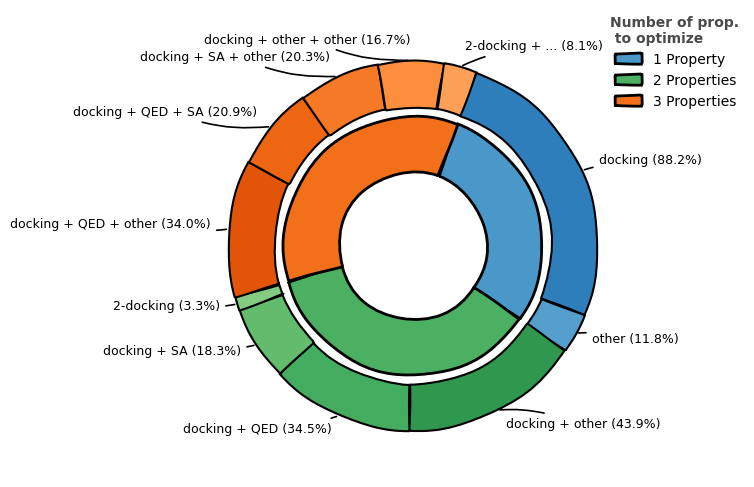

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Prepare Data
df_csv = df_ragg

# Proportions (Replace with your actual 'props' calculation)
inner_proportions = {'1 Property': 0.29, '2 Properties': 0.36, '3 Properties': 0.35}

# 2. Setup Plotting Parameters
cmaps = [plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges]
inner_colors = [cmaps[0](0.6), cmaps[1](0.6), cmaps[2](0.6)]
sketch_style = (0.7, 100, 1.2) # scale, length, randomness

outer_sizes, outer_labels, outer_colors, outer_relative_pct = [], [], [], []

for i, (name, inner_p) in enumerate(inner_proportions.items()):
    n = int(name.split()[0])
    sub_df = df_csv[df_csv['n_props'] == n].sort_values('proportion', ascending=False)
    for j, (_, row) in enumerate(sub_df.iterrows()):
        outer_sizes.append(row['proportion'] * inner_p)
        outer_labels.append(row['type'])
        outer_relative_pct.append(row['proportion'] * 100)
        outer_colors.append(cmaps[i](0.7 - (j / (len(sub_df) + 1)) * 0.4))

# 3. Create Figure
fig, ax = plt.subplots(figsize=(6, 6), facecolor='none')

# 4. Draw Rings
# Outer Ring
wedges_out, _ = ax.pie(outer_sizes, radius=1.0, colors=outer_colors,
                       startangle=70, counterclock=False,
                       wedgeprops=dict(width=0.25, edgecolor='black', linewidth=1.5))

# Inner Ring
inner_rad, inner_w = 0.7, 0.3
inner_label_pos = (inner_rad - inner_w/2) / inner_rad * 0.8
wedges_in, texts_in = ax.pie(list(inner_proportions.values()),
                             radius=inner_rad, colors=inner_colors,
                             startangle=70, counterclock=False,
                             labeldistance=inner_label_pos,
                             textprops={'color': 'black', 'weight': 'bold', 'fontsize': 11},
                             wedgeprops=dict(width=inner_w, edgecolor='black', linewidth=2))

# Apply the "Sloppy" sketch filter to all wedges
for w in wedges_out + wedges_in:
    w.set_sketch_params(*sketch_style)

# 5. Add Annotations with Sloppy Arrows
for i, p in enumerate(outer_sizes):
    if (p / sum(outer_sizes)) > 0.01:
        ang = (wedges_out[i].theta2 + wedges_out[i].theta1) / 2.
        y, x = np.sin(np.deg2rad(ang)), np.cos(np.deg2rad(ang))
        ha = "left" if x > 0 else "right"

        ann = ax.annotate(f"{outer_labels[i]} ({outer_relative_pct[i]:.1f}%)",
                          color="black",
                          xy=(x, y), xytext=(1.1*x, 1.1*y),
                          horizontalalignment=ha, fontsize=9,
                          arrowprops=dict(arrowstyle="-", color="black",
                                          connectionstyle="arc3,rad=0.1", linewidth=1.2))
        ann.arrow_patch.set_sketch_params(*sketch_style)

ax.set(aspect="equal")

leg = ax.legend(wedges_in, inner_proportions.keys(),
                title="Number of prop.\n to optimize",
                loc="center left",
                bbox_to_anchor=(.9, 0.9), # Positions it to the right of the plot
                labelcolor='black',  # Sets all text to black
                fontsize=10, title_fontsize=10,
                frameon=False)
leg.get_title().set_color('#4A4A4A')  # A nice dark grey
leg.get_title().set_weight('bold')

# 2. Make the legend boxes "sloppy" to match the plot
# for patch in leg.get_patches():
#     patch.set_sketch_params(*sketch_style)

# Save with transparent background
plt.savefig('../-Philippe-MolGenDocking/Figures/generation_data/donut_dataset.pdf', bbox_inches='tight')
plt.show()

(array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ]),
 [Text(1.0, 0, '1.00'),
  Text(1.25, 0, '1.25'),
  Text(1.5, 0, '1.50'),
  Text(1.75, 0, '1.75'),
  Text(2.0, 0, '2.00'),
  Text(2.25, 0, '2.25'),
  Text(2.5, 0, '2.50'),
  Text(2.75, 0, '2.75'),
  Text(3.0, 0, '3.00')])

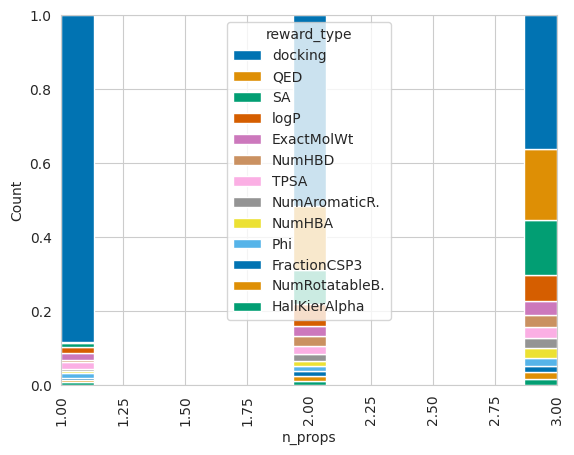

In [251]:
sns.histplot(df, hue="reward_type", x="n_props", alpha=1, multiple="fill", palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)

In [105]:
df.groupby()

,properties,objectives,target,prompt_id,n_props,n_docking_props,source,is_docking,reward_type
0,SA,below,2.01,3034103906320,2,1,test_data/test_prompts,False,SA
1,sample_128610_model_0,minimize,0.0,3034103906320,2,1,test_data/test_prompts,True,docking
2,CalcHallKierAlpha,maximize,0.0,391500,1,0,test_data/test_prompts,False,HallKierAlpha
3,sample_315518_model_0,minimize,0.0,38151039143206,2,1,test_data/test_prompts,True,docking
4,CalcTPSA,below,20.67,38151039143206,2,1,test_data/test_prompts,False,TPSA
...,...,...,...,...,...,...,...,...,...
3082,CalcTPSA,above,19.6,3914219669910,2,1,test_data/test_prompts_ood,False,TPSA
3083,sample_970401_model_0,minimize,0.0,3914219669910,2,1,test_data/test_prompts_ood,True,docking
3084,sample_240638_model_0,minimize,0.0,318710390723,2,1,test_data/test_prompts_ood,True,docking
3085,QED,above,0.36,318710390723,2,1,test_data/test_prompts_ood,False,QED


In [304]:
!ls ../-Philippe-MolGenDocking/Figures


generation_data  MolProps.png		   reaction_data
Litt.png	 property_prediction_data  reaction_data_comparison
